# COCO Image Dataset Testing

## Imports

In [1]:
# Add Utils to path
import sys
sys.path.append('../Utils')  # Adds higher directory to python modules path.

# Utils
from datasets_generators import CocoDetection

# Pytorch
import torchvision.transforms as T
from transformers import DetrImageProcessor

# Other
import os
import cv2
import json
from PIL import ImageDraw
import matplotlib.pyplot as plt

## Load Data

In [2]:
# Paths
imgs_path = "../ExDark_All/Images"
coco_path = "../ExDark_COCO/train_set.json"

# Transforms
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

# COCO Dataset
coco_dataset = CocoDetection(image_directory_path=imgs_path,  annotation_file_path=coco_path, image_processor=image_processor, enhancement="clahe")

# Data
print("Number of images: ", len(coco_dataset))
print("Number of classes: ", len(coco_dataset.coco.getCatIds()))

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Number of images:  3000
Number of classes:  12


# Plots

## Testing Data Processing
Original image vs Facebook Pretrained vs Custom Preprocessing

Original Anno: {'id': 7, 'image_id': 2, 'category_id': 0, 'bbox': ['287', '101', '211', '246'], 'area': 51906.0}
Original Anno: {'id': 8, 'image_id': 2, 'category_id': 3, 'bbox': ['3', '128', '35', '21'], 'area': 735.0}
Original Anno: {'id': 9, 'image_id': 2, 'category_id': 6, 'bbox': ['215', '146', '107', '70'], 'area': 7490.0}

Facebook Image Shape: torch.Size([3, 800, 1066])
Facebook Anno: {'size': tensor([ 800, 1066]), 'image_id': tensor([2]), 'class_labels': tensor([0, 3, 6]), 'boxes': tensor([[0.7850, 0.5973, 0.4220, 0.6560],
        [0.0410, 0.3693, 0.0700, 0.0560],
        [0.5370, 0.4827, 0.2140, 0.1867]]), 'area': tensor([236082.3438,   3342.9761,  34066.5195]), 'iscrowd': tensor([0, 0, 0]), 'orig_size': tensor([375, 500])}

Custom Image Shape: torch.Size([3, 700, 700])
Custom Anno: {'size': tensor([700, 700]), 'image_id': tensor([2]), 'class_labels': tensor([0, 3, 6]), 'boxes': tensor([[0.7850, 0.5979, 0.4214, 0.6557],
        [0.0407, 0.3693, 0.0700, 0.0557],
        [0.537

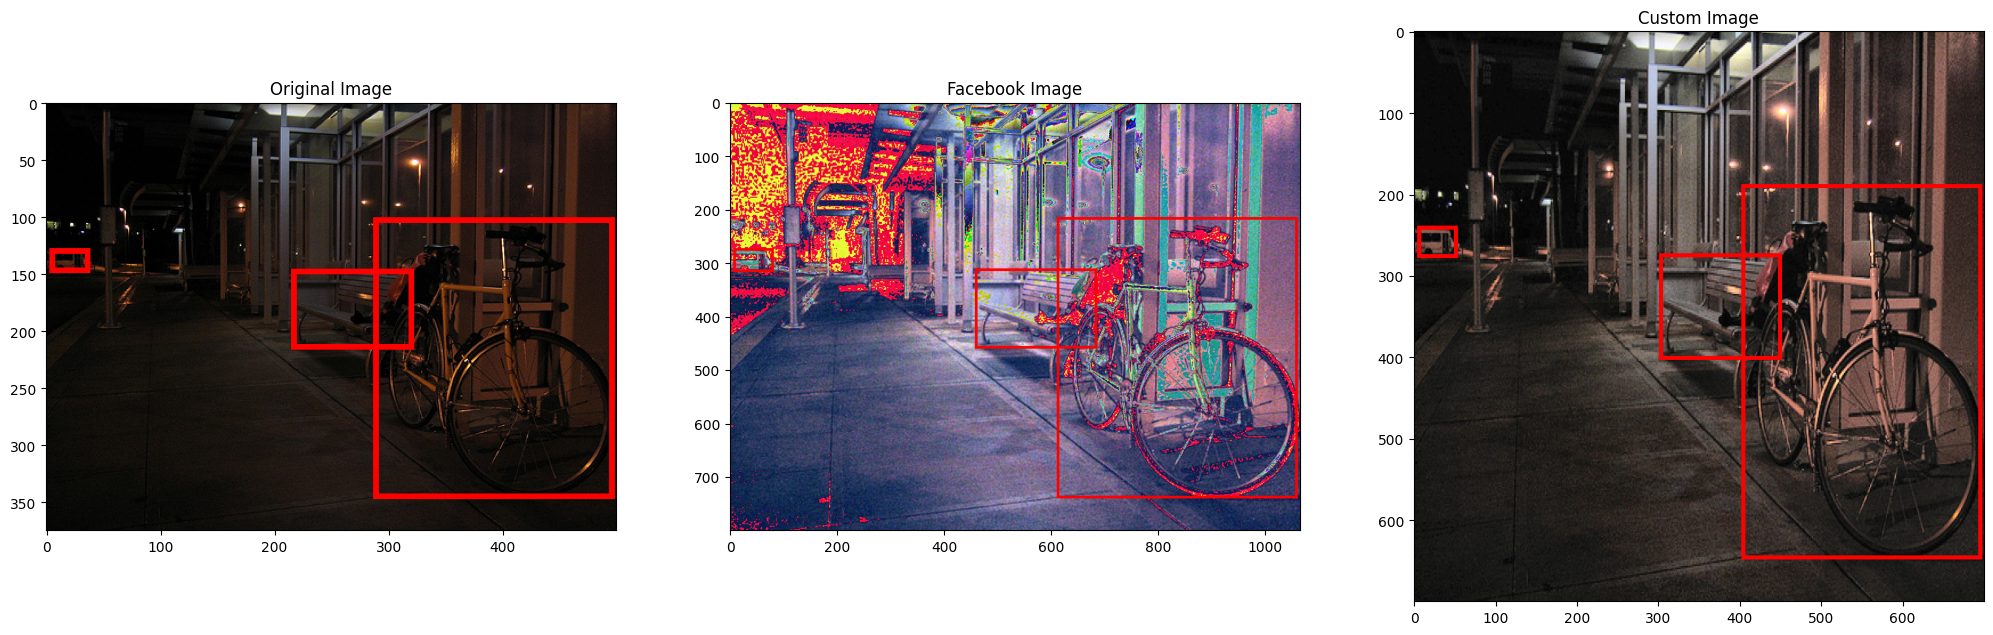

In [3]:
image_id = 2
to_pil_image = T.ToPILImage()

# Original Image
with open(coco_path) as f:
  data = json.load(f)
image_name = data['images'][image_id]['file_name']
og_img = cv2.imread(os.path.join(imgs_path, image_name))
og_img = cv2.cvtColor(og_img, cv2.COLOR_BGR2RGB)
og_img = to_pil_image(og_img)
for ann in data['annotations']:
  if ann['image_id'] == image_id:
    print("Original Anno:", ann)
    og_box = [int(b) for b in ann['bbox']]
    og_box = [og_box[0], og_box[1], og_box[0]+og_box[2], og_box[1]+og_box[3]]
    og_draw = ImageDraw.Draw(og_img)
    og_draw.rectangle(og_box, outline='red', width=5)

# Preprocessed Images
ct_image, ct_anno, fb_image, fb_anno =  coco_dataset[image_id]
print("\nFacebook Image Shape:", fb_image.shape)
print("Facebook Anno:", fb_anno)
print("\nCustom Image Shape:", ct_image.shape)
print("Custom Anno:", ct_anno)
fb_image = to_pil_image(fb_image)
ct_image = to_pil_image(ct_image)
ct_size = ct_anno['size']
fb_size = fb_anno['size']
for ann in ct_anno['boxes']:
  ct_box = [float(b) for b in ann]
  ct_box = [ct_box[0]*ct_size[1], ct_box[1]*ct_size[0], ct_box[2]*ct_size[1], ct_box[3]*ct_size[0]]
  ct_box = [ct_box[0]-ct_box[2]/2, ct_box[1]-ct_box[3]/2, ct_box[0]+ct_box[2]/2, ct_box[1]+ct_box[3]/2]
  ct_draw = ImageDraw.Draw(ct_image)
  ct_draw.rectangle(ct_box, outline='red', width=5)
for ann in fb_anno['boxes']:
  fb_box = [float(b) for b in ann]
  fb_box = [fb_box[0]*fb_size[1], fb_box[1]*fb_size[0], fb_box[2]*fb_size[1], fb_box[3]*fb_size[0]]
  fb_box = [fb_box[0]-fb_box[2]/2, fb_box[1]-fb_box[3]/2, fb_box[0]+fb_box[2]/2, fb_box[1]+fb_box[3]/2]
  fb_draw = ImageDraw.Draw(fb_image)
  fb_draw.rectangle(fb_box, outline='red', width=5)

# Plot
plt.figure(figsize=(25,15))
plt.subplot(1,3,1)
plt.imshow(og_img)
plt.title("Original Image")
plt.subplot(1,3,2)
plt.imshow(fb_image)
plt.title("Facebook Image")
plt.subplot(1,3,3)
plt.imshow(ct_image)
plt.title("Custom Image")
plt.show()